# Examples

This is a [short notebook](https://github.com/dgerosa/precession/blob/master/utils/examples.ipynb) to illustrate some of the key features of the `precession` module. There much more than this in the code but hopefully this is a good starting point. 

In [13]:
import numpy as np
from importlib.machinery import SourceFileLoader
precession = SourceFileLoader("precession", "../precession/precession.py").load_module()
precession_eccentricity = SourceFileLoader("eccentricity", "../precession/eccentricity.py").load_module()

The import syntax above ensures that the online documentation grabs the latest version. For you, it should just be `import precession`, and in case you want to use the eccentric version, import `precession.eccentricity`.
*Note for the usage of the eccentric version of* `precession`: The code is implemented such that almost all the functions available in `precession` can be accessed by just importing its eccentric extension. Some of them are exactly the same as for the circular counterpart; others, specifically those directly involving time or orbital separation, require a different input (briefly, all `r` parameters have been substituted with `(a, e)`). The functions that are specific only to the circular case (like `eval_r` or those related to the remnant properties) cannot be accessed via `precession.eccentricity`. 

## 1. Select a binary configuration.
First, set the constants of motion. These include mass ratio and spin magnitudes:

In [ ]:
q = 0.8
q

In [ ]:
chi1 = 0.5
chi1

In [ ]:
chi2 = 0.9
chi2

From these, find a suitable value of the effective spin within its geometrical limits

In [ ]:
chieff_minus,chieff_plus=precession.chiefflimits(q=q, chi1=chi1, chi2=chi2)
chieff = 0.1
assert chieff>=chieff_minus and chieff<=chieff_plus
chieff

Now the quantities that vary on the radiation-reaction timescale. Specify the orbital separation

In [ ]:
r = 1000
r

Find a suitable value of the asymptotic angular momentum (its boundaries are the spin-orbit resonances):

In [ ]:
kappa_minus,kappa_plus=precession.kappalimits(r=r,chieff=chieff, q=q, chi1=chi1, chi2=chi2)  
kappa = 0.02
assert kappa>=kappa_minus and kappa<=kappa_plus

This is more conventiently done by specifying a dimensionless number, e.g.

In [ ]:
kappa = precession.kapparescaling(kappatilde=0.5, r=r, chieff=chieff, q=q, chi1=chi1, chi2=chi2)
kappa

Finally, the precession-timescale variation is encoded in the weighted spin difference. Its limits are given by the solutions of a cubic polynomial:

In [ ]:
deltachi_minus,deltachi_plus = precession.deltachilimits(kappa=kappa,r=r,chieff=chieff,q=q,chi1=chi1,chi2=chi2)
deltachi=-0.1
assert deltachi>=deltachi_minus and deltachi<=deltachi_plus

You can also sample deltachi from its PN-weighted porability density function

In [ ]:
deltachi = precession.deltachisampling(kappa=kappa, r=r, chieff=chieff, q=q, chi1=chi1, chi2=chi1, N=1)

Or, as before, specify a dimensionless number, e.g.

In [ ]:
deltachi = precession.deltachirescaling(deltachitilde=0.4, kappa=kappa, r=r, chieff=chieff, q=q, chi1=chi1, chi2=chi2)
deltachi

From these quantities, one can compute the spin angles

In [ ]:
theta1, theta2, deltaphi = precession.conserved_to_angles(deltachi=deltachi, kappa=kappa, r=r, chieff=chieff, q=q, chi1=chi1, chi2=chi2)
theta1,theta2,deltaphi

The inverse operation is

In [ ]:
deltachi_, kappa_, chieff_ = precession.angles_to_conserved(theta1=theta1, theta2=theta2, deltaphi=deltaphi, r=r, q=q, chi1=chi1, chi2=chi2)
assert np.isclose(deltachi_,deltachi) and np.isclose(kappa_,kappa) and np.isclose(chieff_,chieff)

One can now compute various derived quantities including:
 
* The precession period
* The total precession angle
* Two flavors of the precession estimator chip
* The spin morphology
* ... and many more!


In [ ]:
tau = precession.eval_tau(kappa=kappa, r=r, chieff=chieff, q=q, chi1=chi1, chi2=chi2)
tau

In [ ]:
alpha = precession.eval_alpha(kappa=kappa, r=r, chieff=chieff, q=q, chi1=chi1, chi2=chi2)
alpha

In [ ]:
chip_averaged = precession.eval_chip(deltachi=deltachi,kappa=kappa,r=r,chieff=chieff,q=q,chi1=chi1,chi2=chi2,which="averaged")
chip_averaged

In [ ]:
chip_rms = precession.eval_chip(deltachi=deltachi,kappa=kappa,r=r,chieff=chieff,q=q,chi1=chi1,chi2=chi2,which="rms")
chip_rms

In [ ]:
morph = precession.morphology(kappa=kappa, r=r, chieff=chieff, q=q, chi1=chi1, chi2=chi2 )
morph

## 2. Inspiral

Let's now evolve that binary configuration down to r=10M. 

In [ ]:
rvals = [r, 10] # Specify all the outputs you want here
outputs = precession.inspiral_precav(kappa=kappa,r=rvals,chieff=chieff,q=q,chi1=chi1,chi2=chi2)
outputs

The same evolution can also be done with an orbit-averaged scheme (note that now you have to specify deltachi as well). This is slow:

In [ ]:
outputs = precession.inspiral_orbav(deltachi=deltachi, kappa=kappa,r=rvals,chieff=chieff,q=q,chi1=chi1,chi2=chi2)
outputs

Let's now take this binary at r=10M, and propagate it back to past time infinity:

In [ ]:
rvals = [outputs['r'][0,-1], np.inf] # Specify all the outputs you want here
outputs = precession.inspiral_precav(kappa=outputs['kappa'][0,-1],r=rvals,chieff=chieff,q=q,chi1=chi1,chi2=chi2)
outputs

## 3. Precession average what you like

The code also allow you to precession-average quantities specified by the users. For instance, let's compute the average of deltachi. 

In [ ]:
def func(deltachi):
    return deltachi

deltachiav_ = precession.precession_average(kappa=kappa, r=r, chieff=chieff, q=q, chi1=chi1, chi2=chi2, func=func)
deltachiav_

For this specific case, the averaged can also be done semi-analytically in terms of elliptic integrals (though in general this is not possible). Let's check we get the same result:

In [ ]:
u = precession.eval_u(r, q)
deltachiminus,deltachiplus,deltachi3 = precession.deltachiroots(kappa=kappa, u=u, chieff=chieff, q=q, chi1=chi1, chi2=chi2)
m = precession.elliptic_parameter(kappa=kappa, u=u, chieff=chieff, q=q, chi1=chi1, chi2=chi2,
                                  precomputedroots=np.stack([deltachiminus, deltachiplus, deltachi3]))
deltachiav = precession.inverseaffine( precession.deltachitildeav(m),  deltachiminus, deltachiplus)
deltachiav

In [ ]:
(deltachiav_-deltachiav)/deltachiav

This is also an example of  how providing the optional quantity `precomputedroots` speeds up the computation.

## 4. Evolution of an eccentric and precessing binary

To evolve an eccentric and spin-precessing black hole binary from a larger semi-major axis (which can be thought of as a proxy for the orbital separation) to a smaller one, it is necessary to also state the initial eccentricity along with information about the masses and spins of the system.

In [17]:
#intial semi major axis ( in geometric units)
np.random.seed(42)
a0= 100
#final semi major axis
af= 10
a_array= np.linspace(a0, af, 100) #array of semi-major axis values for the inspiral
#initial eccentricity
e0 = 0.6

In [18]:
#spin parameters
chi1 =np.random.uniform(0.1, 1)
chi2 =np.random.uniform(0.1, 1)
theta1, theta2, deltaphi = precession_eccentricity.isotropic_angles(N=1)
#mass parameters
q = np.random.uniform(0.1, 1)


In [19]:
output_ecc=precession_eccentricity.inspiral_precav(theta1=theta1,theta2=theta2,deltaphi=deltaphi,a=a_array,e=e0,q=q,chi1=chi1,chi2=chi2)

Let's compare it with a circular evolution (setting e=0)

In [20]:
output_circ=precession_eccentricity.inspiral_precav(theta1=theta1,theta2=theta2,deltaphi=deltaphi,a=a_array,e=0,q=q,chi1=chi1,chi2=chi2)

The spin angles evolve differently!

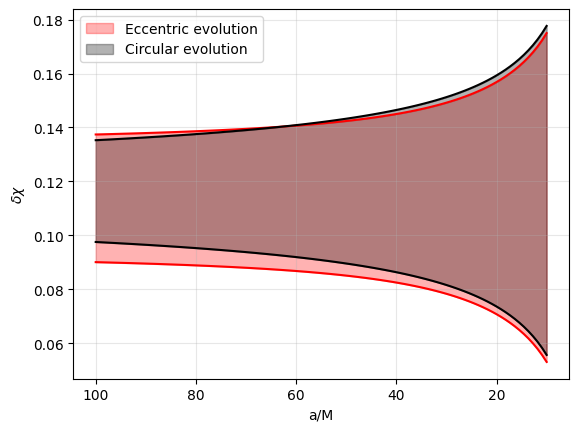

In [21]:
import pylab as plt


plt.plot(output_ecc['a'][0], output_ecc['deltachiminus'][0],color='red')
plt.plot(output_ecc['a'][0], output_ecc['deltachiplus'][0], color='red')
plt.plot(output_circ['a'][0], output_circ['deltachiminus'][0],color='k')
plt.plot(output_circ['a'][0], output_circ['deltachiplus'][0],color='k')


plt.fill_between(
    output_ecc['a'][0],
    output_ecc['deltachiminus'][0],
    output_ecc['deltachiplus'][0],
    color='red',  
    alpha=0.3,
    label='Eccentric evolution'
)


plt.fill_between(
    output_circ['a'][0],
    output_circ['deltachiminus'][0],
    output_circ['deltachiplus'][0],
    color='k',  
    alpha=0.3,
    label='Circular evolution'
)

plt.xlabel('a/M')
plt.ylabel('$\delta \chi$')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

